# Analysis of video games sales

## Introduction

We have data from an online worldwide video games store over the period 1980 to 2016, coming in one table of 16715 entries with 11 variables describing the games by platform, year of release, genre, sales, reviews and rating. We will first prepare the data by making all column names lowercase and changing some data types, then we will look at missing values and decide how to handle those and finally we will calculate and add to the table the total sales over all regions for each game. In the next part we'll look at the number of games released each year and the sales for each platform over the years and decide over which period to do our analysis as earlier years are not as relevant for today's world. We will also look at how reviews, whether from users or critics, affect the total sales, and also which genres sell the most. We then want to look at the top 5 performing genres and platforms for each region, as well as the impact of ESRB ratings on sales of each region. In the final section, we'll test the hypothesis that the user ratings for two of our platforms are the same, and that the user ratings for two of the genres are different. 

## Preprocessing the data

### Taking a look at the data:

In [1]:
!pip install -U sidetable

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sidetable

try:
    games = pd.read_csv('/datasets/games.csv')
except:
    "Error in importing the csv files to pandas."

In [3]:
games.head(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


In [4]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


We have a dataframe with 11 variables, 4 categorical variables and 7 quantitative variables. There are 16715 entries, and we can already see that 6 variables have missing values.

### Making all column names lowercase:

In [5]:
games.columns = games.columns.str.lower()

In [6]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


### Looking for duplicates and problematic entries:

In [7]:
games.duplicated().sum()

0

In [8]:
pd.set_option('display.max_rows', None)

columns_to_check = ['name', 'platform', 'year_of_release', 'genre', 'rating']
for column in columns_to_check:
    print('Unique values of the column {} and their count: \n{}'
          .format(column, games[column].value_counts().sort_index()), end='\n'*2
         )

Unique values of the column name and their count: 
 Beyblade Burst                                                                                                                          1
 Fire Emblem Fates                                                                                                                       1
 Frozen: Olaf's Quest                                                                                                                    2
 Haikyu!! Cross Team Match!                                                                                                              1
 Tales of Xillia 2                                                                                                                       1
'98 Koshien                                                                                                                              1
.hack//G.U. Vol.1//Rebirth                                                                                         

We can already see some issues, the years will need to be converted to integers, as well as the critic scores, there is also 2424 'tbd' ('to be determined' possibly) entries in user scores that might indicate missing values. The Rating columns contains also earlier ratings that are now deprecated (EC and K-A ratings), but there are so few of those that we decide to leave this as is. We also notice that some games have names with 'jp sales' in parenthesis, which might indicate a duplicate entry for these games with only the sales for Japan. Let's have a look at what's going on for these entries:

In [9]:
games[(games['name'].notna()) & \
      (games['name'].str.contains(r'\(jp sales\)'))].head(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
7463,Shin Megami Tensei: Persona 3 (jp sales),PS2,2006.0,Role-Playing,0.0,0.0,0.21,0.0,NaN,NaN,NaN
8597,.hack//G.U. Vol.2//Reminisce (jp sales),PS2,2006.0,Role-Playing,0.0,0.0,0.16,0.0,NaN,NaN,NaN
9249,Ape Escape Academy (jp sales),PSP,2004.0,Misc,0.0,0.0,0.13,0.0,NaN,NaN,NaN
9474,Harvest Moon DS (jp sales),DS,2005.0,Simulation,0.0,0.0,0.13,0.0,NaN,NaN,NaN
9702,Wild ARMs 5 (jp sales),PS2,2006.0,Role-Playing,0.0,0.0,0.12,0.0,NaN,NaN,NaN
10667,Harvest Moon DS Cute (jp sales),DS,2005.0,Simulation,0.0,0.0,0.10,0.0,NaN,NaN,NaN
12353,Fishing Master (jp sales),Wii,2007.0,Sports,0.0,0.0,0.06,0.0,NaN,NaN,NaN
12994,Growlanser: Heritage of War (jp sales),PS2,2006.0,Role-Playing,0.0,0.0,0.05,0.0,NaN,NaN,NaN
13440,Brave Story: New Traveller (jp sales),PSP,2006.0,Role-Playing,0.0,0.0,0.05,0.0,NaN,NaN,NaN
14254,Super Dodgeball Brawlers (jp sales),DS,2008.0,Sports,0.0,0.0,0.03,0.0,NaN,NaN,NaN


Indeed we can see on the table above that these entries only contain the Japan sales. Let's see if there are other similar entries with variations of uppercases for 'jp sales'.

In [10]:
games[(games['name'].notna()) & (games['name'].str.contains(r'\(JP sales\)'))].head(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
4076,Yu-Gi-Oh! Forbidden Memories (JP sales),PS,1999.0,Role-Playing,0.00,0.00,0.45,0.03,NaN,NaN,NaN
4135,The Godfather (JP sales),PS2,2006.0,Action,0.39,0.02,0.00,0.06,NaN,NaN,NaN
4731,Yu-Gi-Oh! The Eternal Duelist Soul (JP sales),GBA,2001.0,Misc,0.00,0.00,0.40,0.01,NaN,NaN,NaN
4781,Warriors Orochi 2 (JP sales),PS2,2008.0,Action,0.00,0.00,0.40,0.00,NaN,NaN,NaN
5217,Naruto: Ultimate Ninja 3 (JP sales),PS2,2005.0,Fighting,0.00,0.00,0.36,0.00,NaN,NaN,NaN
5294,Dragon Ball Z: Budokai Tenkaichi 2 (JP sales),Wii,NaN,Action,0.15,0.05,0.14,0.01,NaN,NaN,NaN
5529,Samurai Warriors 2: Xtreme Legends (JP sales),PS2,2007.0,Action,0.00,0.00,0.33,0.00,NaN,NaN,NaN
5587,Naruto: Ultimate Ninja (JP sales),PS2,2003.0,Fighting,0.00,0.00,0.32,0.00,NaN,NaN,NaN
5870,Fossil Fighters (JP sales),DS,2008.0,Role-Playing,0.00,0.00,0.30,0.00,NaN,NaN,NaN
6634,Dynasty Warriors 6 (JP sales),PS2,2008.0,Action,0.00,0.00,0.25,0.00,NaN,NaN,NaN


It seems here that there are sales for other regions too entered for these 'JP sales' entries. Since our analysis later is only motivated to look at sales for different platforms and genres, and we're not interested in particular games, we decide to leave all these entries as is as it won't change our results. 

Let's also look at the distributions of some of the quantitative variables to see if there are any issues there. 

<AxesSubplot:>

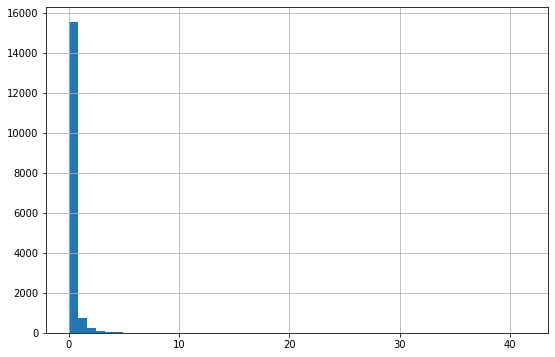

In [11]:
games['na_sales'].hist(bins=50, figsize=(9,6))

In [12]:
games[games['na_sales'] == 0].shape[0]

4508

In [13]:
games[games['na_sales'] == 0].head(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
215,Monster Hunter Freedom 3,PSP,2010.0,Role-Playing,0.0,0.00,4.87,0.00,NaN,NaN,NaN
340,Friend Collection,DS,2009.0,Misc,0.0,0.00,3.67,0.00,NaN,NaN,NaN
385,Monster Hunter 4,3DS,2013.0,Role-Playing,0.0,0.00,3.44,0.00,NaN,NaN,NaN
403,English Training: Have Fun Improving Your Skills!,DS,2006.0,Misc,0.0,0.99,2.32,0.02,NaN,NaN,NaN
428,Dragon Quest VI: Maboroshi no Daichi,SNES,1995.0,Role-Playing,0.0,0.00,3.19,0.00,NaN,NaN,NaN
530,Dragon Quest V: Tenkuu no Hanayome,SNES,1992.0,Role-Playing,0.0,0.00,2.78,0.01,NaN,NaN,NaN
563,Yokai Watch 2 Shinuchi,3DS,2014.0,Role-Playing,0.0,0.00,2.68,0.00,NaN,NaN,NaN
574,Super Mario Bros.: The Lost Levels,NES,1986.0,Platform,0.0,0.00,2.65,0.00,NaN,NaN,NaN
632,Final Fantasy V,SNES,1992.0,Role-Playing,0.0,0.00,2.43,0.02,NaN,NaN,NaN
674,Dragon Warrior Monsters,GB,1998.0,Role-Playing,0.0,0.00,2.34,0.01,NaN,NaN,NaN


<AxesSubplot:>

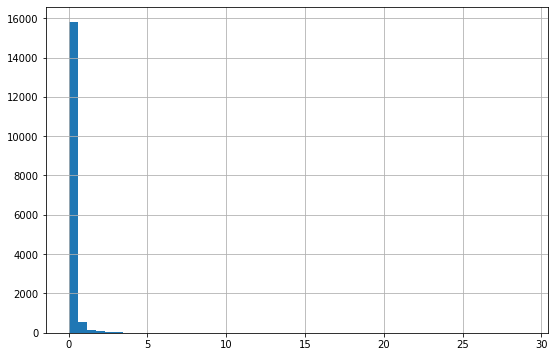

In [14]:
games['eu_sales'].hist(bins=50, figsize=(9,6))

In [15]:
games[games['eu_sales'] == 0].shape[0]

5870

<AxesSubplot:>

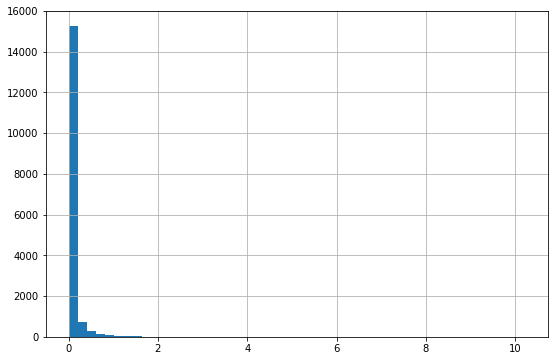

In [16]:
games['jp_sales'].hist(bins=50, figsize=(9,6))

In [17]:
games[games['jp_sales'] == 0].shape[0]

10514

<AxesSubplot:>

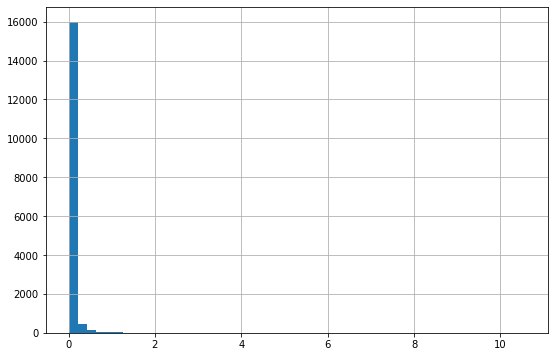

In [18]:
games['other_sales'].hist(bins=50, figsize=(9,6))

In [19]:
games[games['other_sales'] == 0].shape[0]

6601

In [20]:
games[(games['other_sales'] == 0) & (games['na_sales'] == 0) & \
      (games['jp_sales'] == 0) & (games['eu_sales'] == 0)].shape[0]

2

There are many games that didn't make any sales in one of the markets, but almost all those games made sales in one or more other markets, so it's possible that these games just weren't marketed for that market where they didn't make any sales. As a result, we will leave these 0 values as is and won't replace those values.

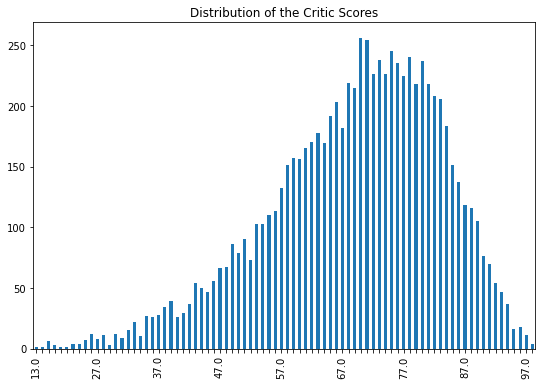

In [21]:
fig, ax = plt.subplots()
(games['critic_score']
 .value_counts()
 .sort_index()
 .plot(kind='bar', figsize=(9,6))
)
every_nth = 10
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
plt.title('Distribution of the Critic Scores')
plt.show()

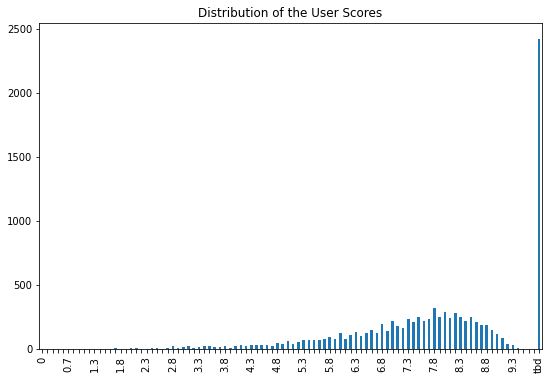

In [22]:
fig, ax = plt.subplots()
(games['user_score']
 .value_counts()
 .sort_index()
 .plot(kind='bar', figsize=(9,6))
)
every_nth = 5
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
plt.title('Distribution of the User Scores')
plt.show()

We see here the many 'tbd' problematic entries for the user scores, that probably mean 'to be determined'. Let's calculate what percentage of the data these represent. We will deal with these values in the next section.

In [23]:
print("There are {:.0%} percent of the entries that have a 'tbd' user score."
      .format(games[games['user_score'] == 'tbd'].shape[0] / games.shape[0])
     )

There are 15% percent of the entries that have a 'tbd' user score.


### Changing data types:

The years are actually integer so it makes sense to convert this column to integers. 

In [24]:
try:
    games = games.astype({'year_of_release':'Int64'})
except:
    print('Error: integer conversion. Please check entries of columns.')
games.dtypes

name                object
platform            object
year_of_release      Int64
genre               object
na_sales           float64
eu_sales           float64
jp_sales           float64
other_sales        float64
critic_score       float64
user_score          object
rating              object
dtype: object

We will treat the 'tbd' values of the user scores columns as missing values and replace them with actual NaN values when doing the numeric conversion below. 

In [25]:
try:
    games['user_score'] = pd.to_numeric(games['user_score'], errors='coerce')
except:
    print('Error. Please check entries of column.')
games.dtypes

name                object
platform            object
year_of_release      Int64
genre               object
na_sales           float64
eu_sales           float64
jp_sales           float64
other_sales        float64
critic_score       float64
user_score         float64
rating              object
dtype: object

The year of release column has been successfully converted to integers, and the user score column to floats.

### Dealing with missing values:

In [26]:
games.stb.missing(style=True)

,missing,total,percent
user_score,"9,125","16,715",54.59%
critic_score,"8,578","16,715",51.32%
rating,"6,766","16,715",40.48%
year_of_release,269,"16,715",1.61%
name,2,"16,715",0.01%
genre,2,"16,715",0.01%
platform,0,"16,715",0.00%
na_sales,0,"16,715",0.00%
eu_sales,0,"16,715",0.00%
jp_sales,0,"16,715",0.00%


There are 6 columns with missing values, 3 of those with 40% or more missing. The missing values of the rating column cannot be infered the most likely rating of a game from other values, but we will replace them with marker 'unknown'. For the year of release of a game, we could research for each game which year it was released, however since there are 269 of games with missing year, and they only represent 2% of the data, we decide to just get rid of those entries for time saving purposes. There are 2 entries missing a name, and 2 missing a genre, and since it's so few, we will just get rid of those entries too. There are too many missing values in the user score and critic score columns for them to be replaced without risking introducing artificial trends in the data, and we don't know why they are missing in the first place so we will leave them as is.

Let's first delete the rows that have missing values in columns of year of release, name, and genre.

In [27]:
# Making a copy of the original dataframe that will be used to fill in values.
games_copy = games.copy()

# Deleting the rows with missing values in those 3 columns.
games_copy.dropna(subset=['year_of_release', 'name', 'genre'], inplace=True)
games_copy.stb.missing(style=True)

,missing,total,percent
user_score,"8,981","16,444",54.62%
critic_score,"8,461","16,444",51.45%
rating,"6,676","16,444",40.60%
name,0,"16,444",0.00%
platform,0,"16,444",0.00%
year_of_release,0,"16,444",0.00%
genre,0,"16,444",0.00%
na_sales,0,"16,444",0.00%
eu_sales,0,"16,444",0.00%
jp_sales,0,"16,444",0.00%


In [28]:
games_copy['rating'] = games_copy['rating'].fillna('unknown')
games_copy.stb.freq(['rating'], style=True)

,rating,count,percent,cumulative_count,cumulative_percent
0,unknown,"6,676",40.60%,"6,676",40.60%
1,E,"3,921",23.84%,"10,597",64.44%
2,T,"2,905",17.67%,"13,502",82.11%
3,M,"1,536",9.34%,"15,038",91.45%
4,E10+,"1,393",8.47%,"16,431",99.92%
5,EC,8,0.05%,"16,439",99.97%
6,K-A,3,0.02%,"16,442",99.99%
7,RP,1,0.01%,"16,443",99.99%
8,AO,1,0.01%,"16,444",100.00%


### Adding the total sales to the dataframe:

In [29]:
games_copy['total_sales'] = games_copy[['na_sales', 'eu_sales', 'jp_sales', \
                                            'other_sales']].sum(axis=1)
games_copy.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,unknown,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,unknown,31.38


In [30]:
# Doing the same for our original table

games['total_sales'] = (games[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']]
                        .sum(axis=1)
                       )

## Analysis of the data

### Game releases per year:

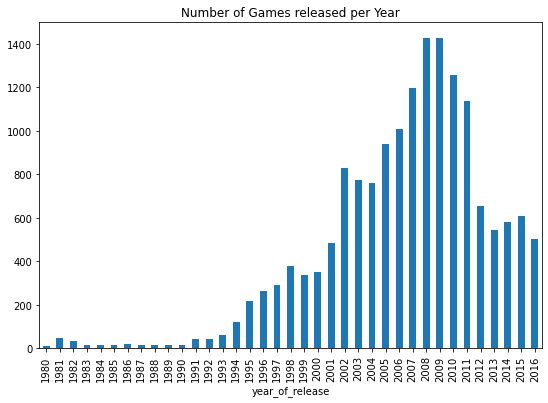

In [31]:
games_copy.groupby('year_of_release')['name'].count().plot(kind='bar', figsize=(9,6))
plt.title('Number of Games released per Year')
plt.show()

Looking at the number of games released per year, we see that before 1994 a lot fewer games were released, and the number exploded after 2001 to get as high as 1400 games released in 2008 and 2009, then it it fell back to around 600 after 2012. Given that trends and taste of the public also evolve with time, it makes more sense to only analyse recent years, after 2001, as old data might not be relevant for today's world. 

### Sales by platform:

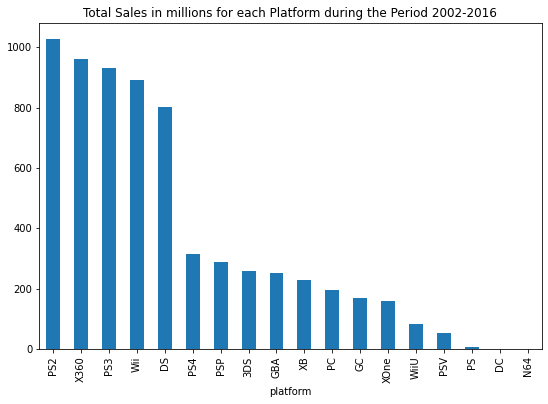

In [32]:
(games_copy
 .query('year_of_release > 2001')
 .groupby('platform')['total_sales']
 .sum()
 .sort_values(ascending=False)
 .plot(kind='bar', figsize=(9,6))
)
plt.title('Total Sales in millions for each Platform during the Period 2002-2016')
plt.show()

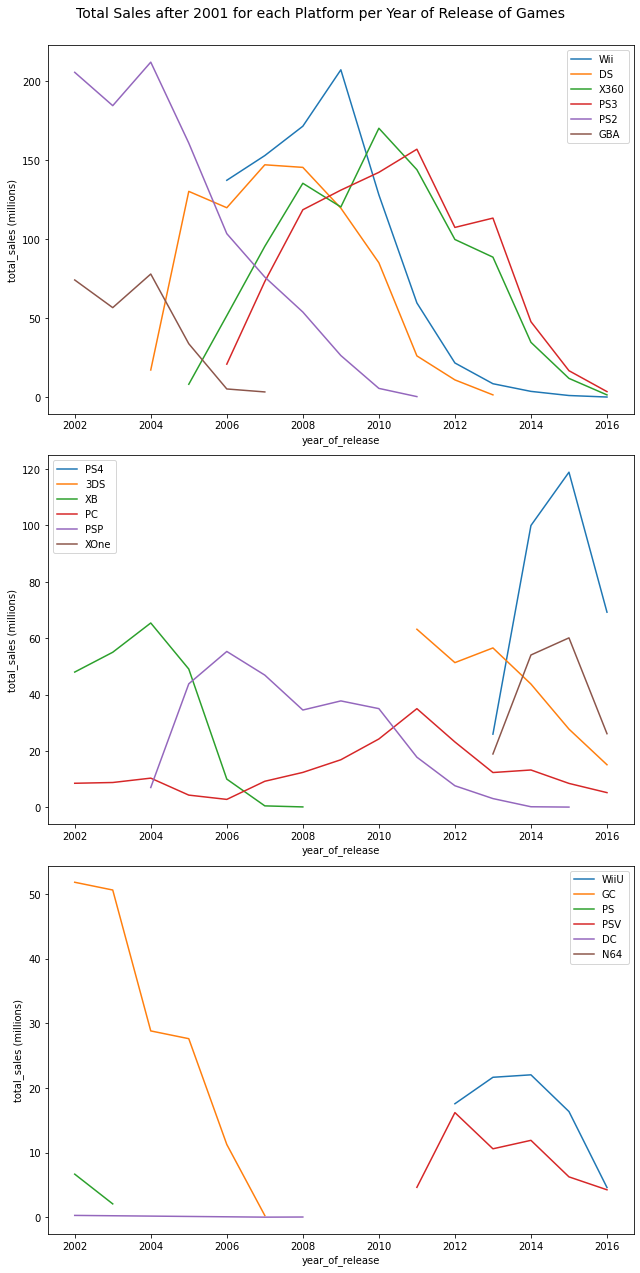

In [33]:
recent_platforms = list(
    games_copy.query('year_of_release > 2001')['platform'].unique()
)

g = (games_copy
     .query('year_of_release > 2001')
     .groupby(['platform', 'year_of_release'])['total_sales']
     .sum()
     .reset_index(level=['platform', 'year_of_release'])
    )

fig,ax = plt.subplots(3, figsize = (9,18))
fig.suptitle('Total Sales after 2001 for each Platform per Year of Release of Games', fontsize=14)

for plat in recent_platforms:
    ind_plat = recent_platforms.index(plat)
    if ind_plat < 6:
        i = 0
    elif ind_plat < 12:
        i = 1
    else:
        i = 2
    ax[i].plot(g[g.platform == plat].year_of_release, g[g.platform == plat].total_sales, label=plat)
    ax[i].set_xlabel("year_of_release")
    ax[i].set_ylabel("total_sales (millions)")
    ax[i].legend(loc='best')
    
fig.tight_layout()
fig.subplots_adjust(top=0.95)
    
plt.show()

The most profitable platforms during the period 2002-2016 were PS2, DS, Wii, X360, PS3, with peaks as high as 200 millions dollars for Wii and PS2, and others reaching around 150 millions dollars in total sales. For recent releases, WiiU, and PSV are shrinking and their sales stayed below 25 millions dollars, 3DS and XOne had some success with sales peaking at 60 millions dollars but are now declining. PS4 is the only platform that had the most recent success with sales around 120 millions dollars in 2015.

We can see above that most platforms seem to have an average lifespan of about 10 years, the most popular growing very fast in the first 3 years, then reaching a peak or two for a few years, and finally declining rapidly in the last 3 to 4 years. The period where the sales are the most important seem to be around 4 years. Therefore it makes sense to do our analysis on data only dating back from 2013 and beyond, and to only look at platforms that are the most recent release of the model, and that have not finished their lifespan cycle. Taking this into consideration and looking at the graph above, we will only analyse the 6 following platforms: PS4, XOne, WiiU, PSV, 3DS, and PC.

In [34]:
relevant_platforms = ['PS4', 'XOne', 'WiiU', 'PSV', '3DS', 'PC']
recent_games_copy = games_copy.query(
    'platform in @relevant_platforms & year_of_release >= 2013'
)

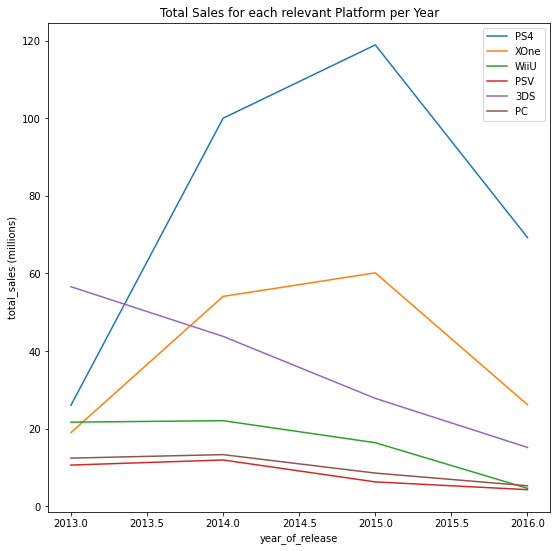

In [35]:
g = (recent_games_copy
     .groupby(['platform', 'year_of_release'])['total_sales']
     .sum()
     .reset_index(level=['platform', 'year_of_release'])
    )

fig,ax = plt.subplots(figsize = (9,9))

for plat in relevant_platforms:
    ax.plot(g[g.platform == plat].year_of_release, g[g.platform == plat].total_sales, label=plat)

ax.set_xlabel("year_of_release")
ax.set_ylabel("total_sales (millions)")
ax.legend(loc='best')
plt.title('Total Sales for each relevant Platform per Year')
plt.show()

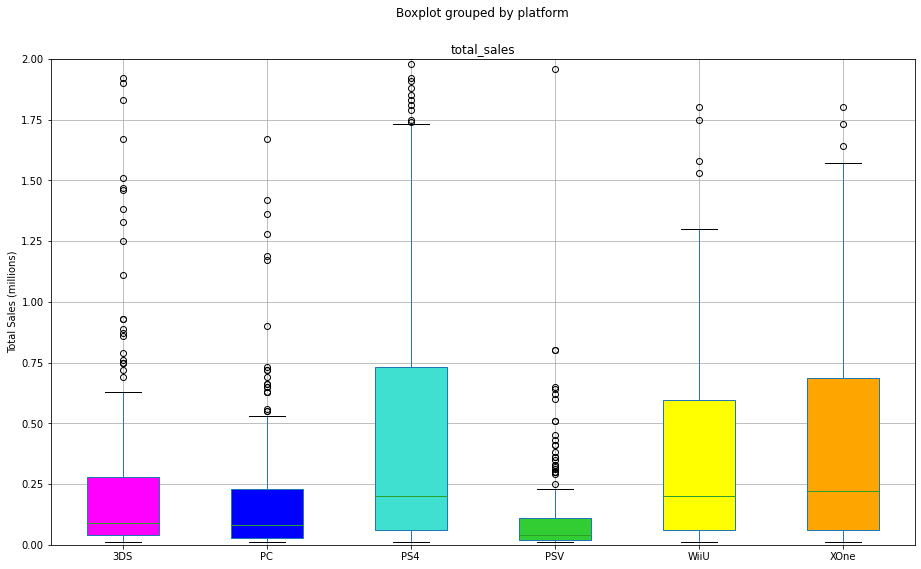

In [36]:
from matplotlib.patches import PathPatch

bplot = (recent_games_copy
         .boxplot(column='total_sales', by='platform', figsize=(15,9), \
                  return_type='both', patch_artist=True)
        )


colors = ['magenta', 'blue', 'turquoise', 'limegreen', 'yellow', 'orange']
for row_key, (ax,row) in bplot.iteritems():
    ax.set_xlabel('')
    for i,box in enumerate(row['boxes']):
        box.set_facecolor(colors[i])
        
plt.ylim([0,2])
plt.ylabel('Total Sales (millions)')
plt.show()

Medians for PS4, WiiU, and XOne are just below 250K dollars, while medians for 3DS, PC, and PSV are below 100K. XOne has the highest median, but PS4 has the bigger interquartile range. There are many outliers for all platforms, because many games do not sell at all, which brings the median low, whereas games with significant sales appear then as outliers.

### Effect of reviews on sales for the PS3 platform:

In [37]:
# Calculating the correlation coefficient between user score and sales

PS4_data = recent_games_copy[recent_games_copy['platform'] == 'PS4']
PS4_data['user_score'].corr(PS4_data['total_sales'])

-0.031957110204556376

In [38]:
PS4_data['critic_score'].corr(PS4_data['total_sales'])

0.40656790206178095

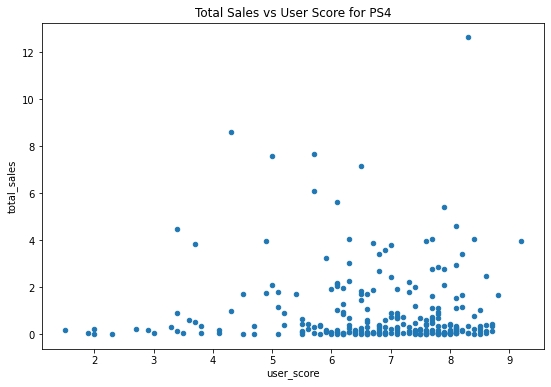

In [39]:
PS4_data.plot(kind='scatter', x='user_score', y='total_sales', figsize=(9,6))
plt.title('Total Sales vs User Score for PS4')
plt.show()

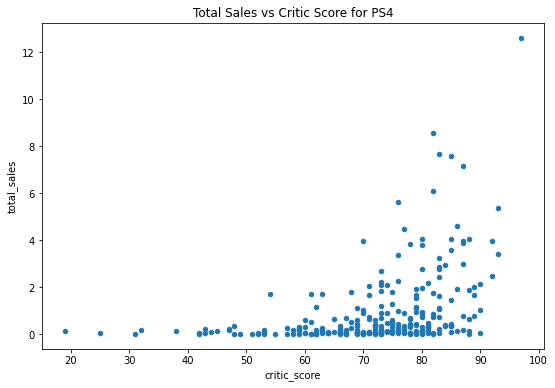

In [40]:
PS4_data.plot(kind='scatter', x='critic_score', y='total_sales', figsize=(9,6))
plt.title('Total Sales vs Critic Score for PS4')
plt.show()

Looking at total sales for games released on the PS4 platform, surprisingly there is close to zero linear relationship between user reviews and sales. The correlation coefficient is higher between the critic scores and the sales, but it is a weak positive linear relationship, as seen on the graph as well. A better score influences lightly the sales, but we would have expected a stronger relationship.  

Let's see how these same games did on other platforms:

In [41]:
# Creating a list of the games sold on PS4 after 2012
games_PS4 = PS4_data['name'].to_list()

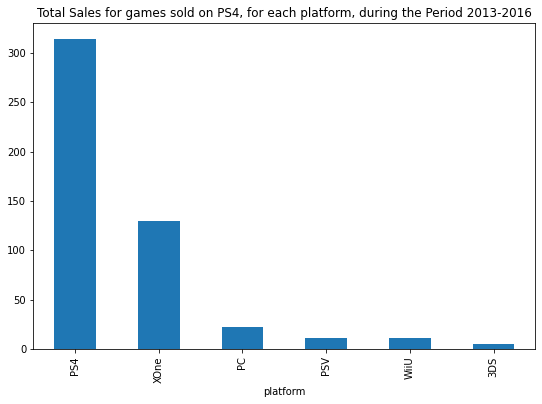

In [42]:
platforms2 = (recent_games_copy[recent_games_copy['name'].isin(games_PS4)]
             .groupby('platform')['total_sales']
             .sum()
             .sort_values(ascending=False)
            )
platforms2.plot(kind='bar', figsize=(9,6))
plt.title('Total Sales for games sold on PS4, for each platform, during the Period 2013-2016')
plt.show()

In [43]:
# Linear correlation coefficient between user score and total sales on other 
# platforms for games sold on PS4

(recent_games_copy
 .query('(name in @games_PS4) & (platform != "PS4")')['user_score']
 .corr(recent_games_copy
       .query('(name in @games_PS4) & (platform != "PS4")')['total_sales']
      )
)

-0.08455951291945428

In [44]:
# Linear correlation coefficient between critic score and total sales on other 
# platforms for games sold on PS4 

(recent_games_copy
 .query('(name in @games_PS4) & (platform != "PS4")')['critic_score']
 .corr(recent_games_copy
       .query('(name in @games_PS4) & (platform != "PS4")')['total_sales']
      )
)

0.2852311608093498

The weak positive correlation we saw earlier between reviews and sales is similar, if not weaker.

### Games by genre:

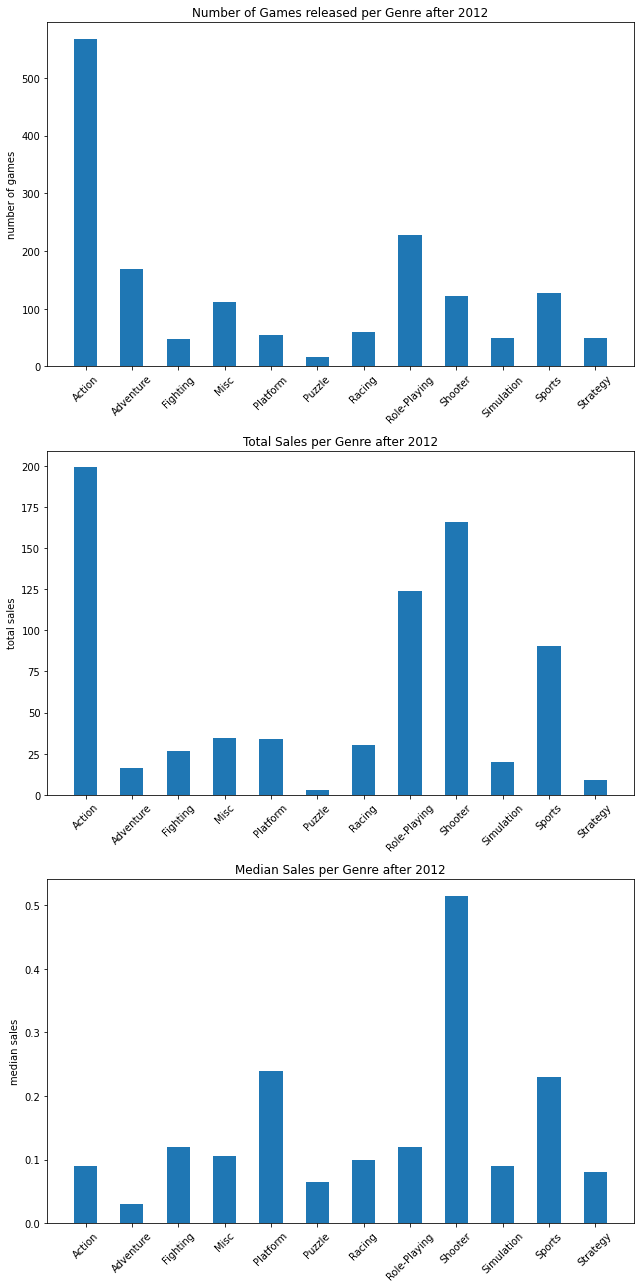

In [45]:
fig, ax = plt.subplots(3, figsize=(9,18))

labels = list(recent_games_copy['genre'].sort_values().unique())
x = np.arange(len(labels))
width = 0.5

ax[0].bar(x, recent_games_copy.groupby('genre')['name'].count().tolist(), width)
ax[0].set_xticks(x)
ax[0].set_xticklabels(labels, rotation=45)
ax[0].set_ylabel("number of games")
ax[0].set_title('Number of Games released per Genre after 2012')


ax[1].bar(x, recent_games_copy.groupby('genre')['total_sales'].sum(), width)
ax[1].set_xticks(x)
ax[1].set_xticklabels(labels, rotation=45)
ax[1].set_ylabel("total sales")
ax[1].set_title('Total Sales per Genre after 2012')

ax[2].bar(x, recent_games_copy.groupby('genre')['total_sales'].median(), width)
ax[2].set_xticks(x)
ax[2].set_xticklabels(labels, rotation=45)
ax[2].set_ylabel('median sales')
ax[2].set_title('Median Sales per Genre after 2012')

fig.tight_layout()

plt.show()

Most of the games released after 2012 were action games, and the total sales for this genre reflects that with highest sales made in this genre, but the median for this genre is actually a lot lower than for many other genres. The genre with the highest median sale is shooter, followed by platform and sports. The genres with the highest total sales were action, role-playing, shooter, and sports. Looking at both median and total sales, the least profitable genres are puzzle, strategy, and adventure, even though adventure had many games released in this period compared to some other genres.

## User profiles for each region

### Top 5 platforms for each region:

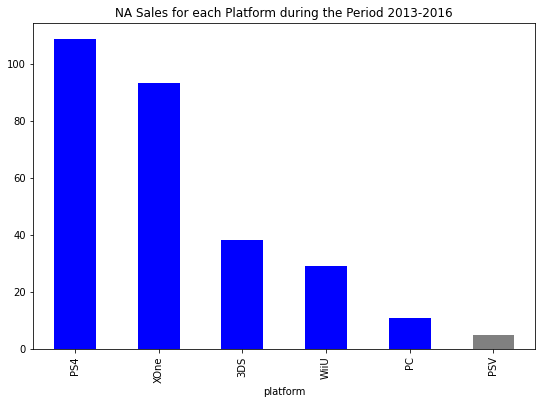

In [46]:
NA_platforms = (recent_games_copy
             .groupby('platform')['na_sales']
             .sum()
             .sort_values(ascending=False)
            )
colors = np.where(NA_platforms.index.isin(NA_platforms.index.tolist()[0:5]), \
                  'blue', 'grey')
NA_platforms.plot(kind='bar', figsize=(9,6), color=colors)
plt.title('NA Sales for each Platform during the Period 2013-2016')
plt.show()

In [47]:
print('The top 5 platforms for North America sales were: {}.'.format(
    ', '.join(NA_platforms.index.tolist()[0:5])))

The top 5 platforms for North America sales were: PS4, XOne, 3DS, WiiU, PC.


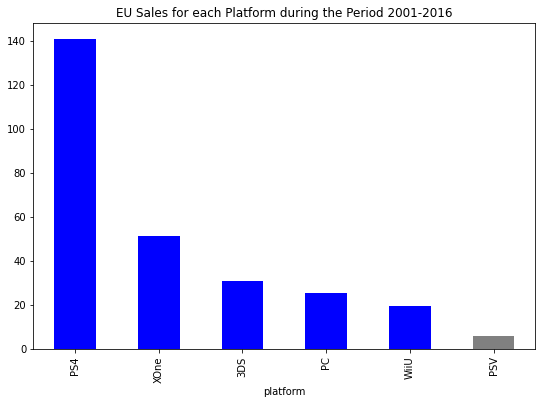

In [48]:
EU_platforms = (recent_games_copy
             .groupby('platform')['eu_sales']
             .sum()
             .sort_values(ascending=False)
            )
colors = np.where(EU_platforms.index.isin(EU_platforms.index.tolist()[0:5]), \
                  'blue', 'grey')
EU_platforms.plot(kind='bar', figsize=(9,6), color=colors)
plt.title('EU Sales for each Platform during the Period 2001-2016')
plt.show()

In [49]:
print('The top 5 platforms European sales were: {}.'.format(
    ', '.join(EU_platforms.index.tolist()[0:5])))

The top 5 platforms European sales were: PS4, XOne, 3DS, PC, WiiU.


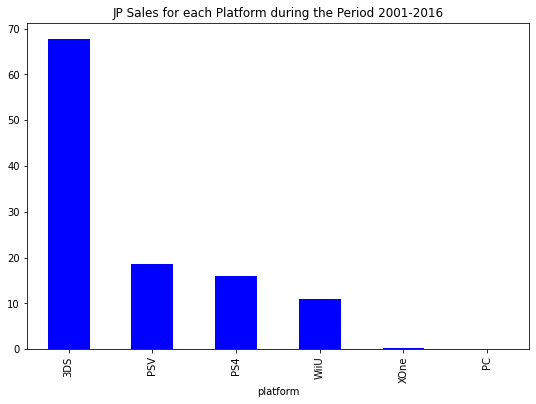

In [50]:
JP_platforms = (recent_games_copy
             .groupby('platform')['jp_sales']
             .sum()
             .sort_values(ascending=False)
            )
colors = np.where(JP_platforms.index.isin(JP_platforms.index.tolist()[0:5]), \
                  'blue', 'grey')
JP_platforms.plot(kind='bar', figsize=(9,6), color=colors)
plt.title('JP Sales for each Platform during the Period 2001-2016')
plt.show()

In [51]:
print('The top 5 platforms for Japan sales were: {}.'.format(
    ', '.join(JP_platforms.index.tolist()[0:5])))

The top 5 platforms for Japan sales were: 3DS, PSV, PS4, WiiU, XOne.


The top 5 performing platforms for North America and Europe were the same, whereas those for Japan were different with the inclusion of PSV instead of PC for Japan. 

### Top 5 Genres for each region:

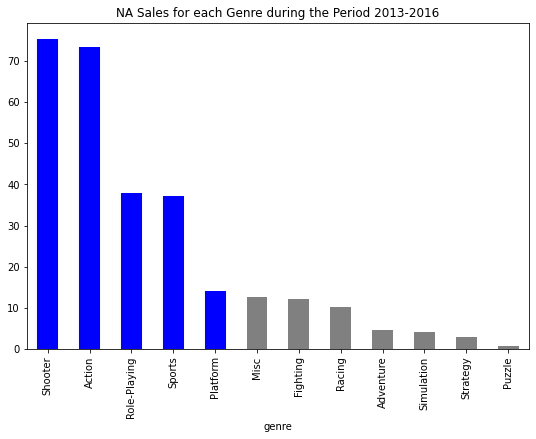

In [52]:
NA_genres = (recent_games_copy
             .groupby('genre')['na_sales']
             .sum()
             .sort_values(ascending=False)
            )
colors = np.where(NA_genres.index.isin(NA_genres.index.tolist()[0:5]), \
                  'blue', 'grey')
NA_genres.plot(kind='bar', figsize=(9,6), color=colors)
plt.title('NA Sales for each Genre during the Period 2013-2016')
plt.show()

In [53]:
print('The top 5 genres for North America were: {}.'.format(
    ', '.join(NA_genres.index.tolist()[0:5])))

The top 5 genres for North America were: Shooter, Action, Role-Playing, Sports, Platform.


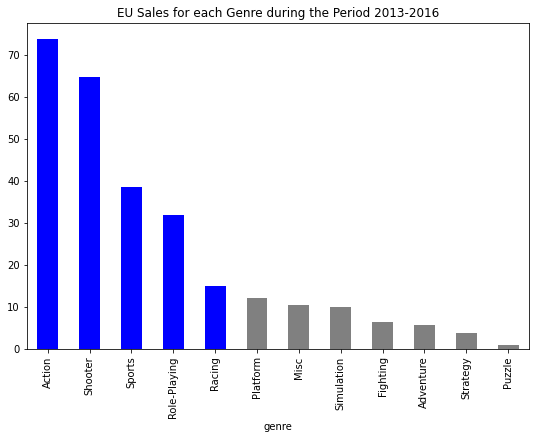

In [54]:
EU_genres = (recent_games_copy
             .groupby('genre')['eu_sales']
             .sum()
             .sort_values(ascending=False)
            )
colors = np.where(EU_genres.index.isin(EU_genres.index.tolist()[0:5]), \
                  'blue', 'grey')
EU_genres.plot(kind='bar', figsize=(9,6), color=colors)
plt.title('EU Sales for each Genre during the Period 2013-2016')
plt.show()

In [55]:
print('The top 5 genres for Europe were: {}.'.format(
    ', '.join(EU_genres.index.tolist()[0:5])))

The top 5 genres for Europe were: Action, Shooter, Sports, Role-Playing, Racing.


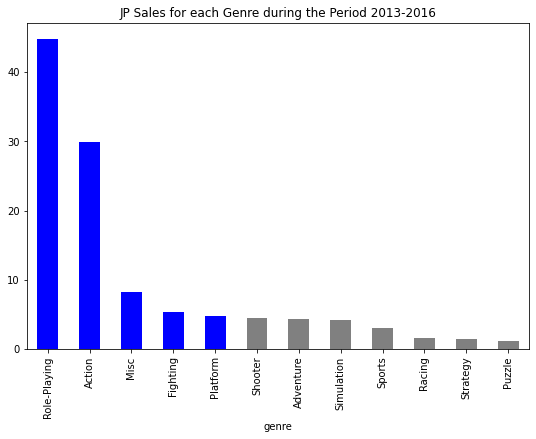

In [56]:
JP_genres = (recent_games_copy
             .groupby('genre')['jp_sales']
             .sum()
             .sort_values(ascending=False)
            )
colors = np.where(JP_genres.index.isin(JP_genres.index.tolist()[0:5]), \
                  'blue', 'grey')
JP_genres.plot(kind='bar', figsize=(9,6), color=colors)
plt.title('JP Sales for each Genre during the Period 2013-2016')
plt.show()

In [57]:
print('The top 5 genres for Japan were: {}.'.format(
    ', '.join(JP_genres.index.tolist()[0:5])))

The top 5 genres for Japan were: Role-Playing, Action, Misc, Fighting, Platform.


In decreasing order of sales, the top 5 genres for North America were: Shooter, Action, Role-Playing, Sports, Platform; the top 5 genres for Europe were: Action, Shooter, Sports, Role-Playing, Racing; and the top 5 genres for Japan were: Role-Playing, Action, Misc, Fighting, Platform. We see that all 3 regions share 2 of the same genres in their top 5 which are Action and Role-playing. North America and Europe also have the Shooter and Sports genres in their top 5, but not in the same order. North America fifth genre was Platform whereas Europe's was Racing. Japan on shared Platform genre with North America, and also had Fighting and Misc in its top 5. 

### Effect of ESRB ratings on each region:

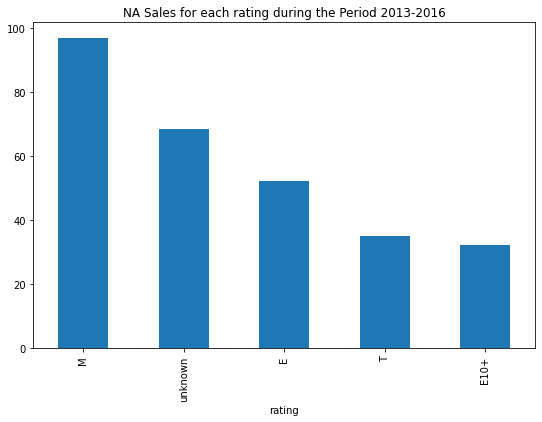

In [58]:
NA_rating = (recent_games_copy
             .groupby('rating')['na_sales']
             .sum()
             .sort_values(ascending=False)
            )
NA_rating.plot(kind='bar', figsize=(9,6))
plt.title('NA Sales for each rating during the Period 2013-2016')
plt.show()

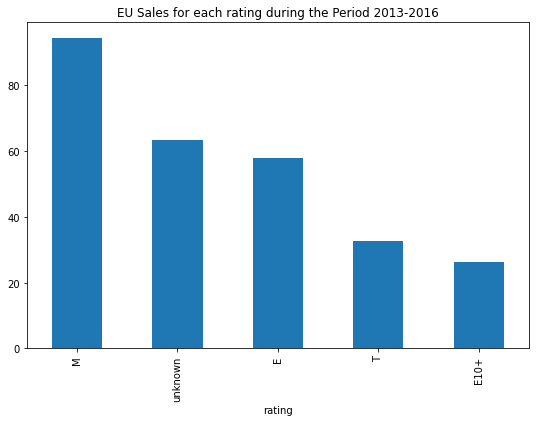

In [59]:
EU_rating = (recent_games_copy
             .groupby('rating')['eu_sales']
             .sum()
             .sort_values(ascending=False)
            )
EU_rating.plot(kind='bar', figsize=(9,6))
plt.title('EU Sales for each rating during the Period 2013-2016')
plt.show()

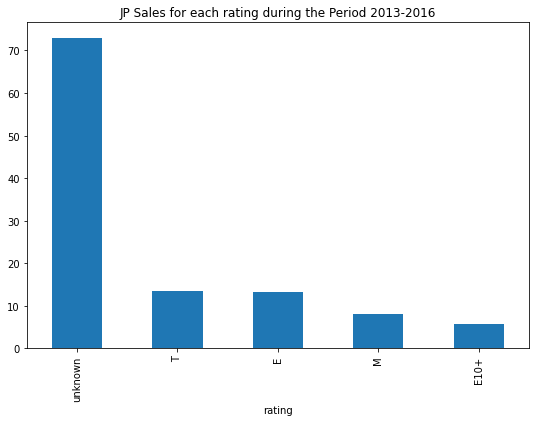

In [60]:
JP_rating = (recent_games_copy
             .groupby('rating')['jp_sales']
             .sum()
             .sort_values(ascending=False)
            )
JP_rating.plot(kind='bar', figsize=(9,6))
plt.title('JP Sales for each rating during the Period 2013-2016')
plt.show()

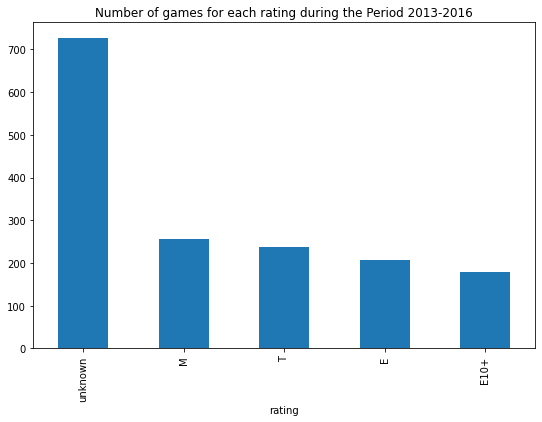

In [61]:
number_rating = (recent_games_copy
             .groupby('rating')['name']
             .count()
             .sort_values(ascending=False)
            )
number_rating.plot(kind='bar', figsize=(9,6))
plt.title('Number of games for each rating during the Period 2013-2016')
plt.show()

North America and Europe have the same pattern of sales for each rating, with most sales being made in the Mature rating, whereas Japan had most of its sales for the games for which we don't have a rating, which makes sense since Japan has another rating system that is different from the ESRB. For North America and Europe, the Everyone rating also fared better than the Teen rating despite having less games released.

## Hypotheses testing

### Xbox One and PC user ratings are the same:

We want to test whether the average user ratings for the Xbox One and PC platforms are the same. The null hypothesis will be that the mean of user ratings for the Xbox One and the mean of user ratings for the PC are equal. Our alternative hypothsesis is that the two means differ. We choose a significance level alpha of 0.05 as we are ok with a 5% risk of concluding that a difference exists when there is no actual difference.

In [62]:
from scipy import stats as st

alpha = 0.05
results = st.ttest_ind(
    recent_games_copy.loc[recent_games_copy['platform'] == 'XOne','user_score'], \
    recent_games_copy.loc[recent_games_copy['platform'] == 'PC','user_score'], \
    nan_policy='omit'
)
print('p-value:', results.pvalue)
if results.pvalue < alpha:
    print('We reject the null hypothesis.')
else: 
    print('We cannot reject the null hypothesis.')

p-value: 0.14012658403611503
We cannot reject the null hypothesis.


We can conclude that we cannot reject the null hypothesis that the average user ratings for both platforms is equal.

### Action and Sports genres user ratings are different:

Let's see now if the average user rating for the Action and Sports genres are different. Our null hypothesis will be that the mean of the user score for the Action genre is equal to the mean user score of Sports genre. Our alternative hypothsesis is that the two means differ. We again choose a significance level alpha of 0.05.

In [63]:
from scipy import stats as st

alpha = 0.05
results = st.ttest_ind(
    recent_games_copy.loc[recent_games_copy['genre'] == 'Action','user_score'], \
    recent_games_copy.loc[recent_games_copy['genre'] == 'Sports','user_score'], \
    nan_policy='omit'
)
print('p-value:', results.pvalue)
if results.pvalue < alpha:
    print('We reject the null hypothesis.')
else: 
    print('We cannot reject the null hypothesis.')

p-value: 6.528226290437357e-15
We reject the null hypothesis.


We reject the null hypothesis that the average user ratings for Sports and Action genres are equal, and therefore can conclude that they are different.

## Conclusion

In this report, we analyzed data from an online worldwide video games store over the period 1980 to 2016, coming in one table of 16715 entries with 11 variables describing the games by platform, year of release, genre, sales, reviews and rating.

In the first part of this report the data was preprocessed by doing the following:
All columns names were transformed to lowercase, no duplicated rows were found, year of release and critic score columns were converted to integers and 15% of the user score column were 'tbd' entries that were treated as missing values here, then this column was converted to floats. There were 6 columns with missing values, 3 of those with 40% or more missing. The rating column was left as is, as well as the user score and critic score columns, and the rows with missing values in year of release, name, and genre were all deleted as there were less than 2% of these. The total sales accross all regions was calculated and added to the table.

In the next part, we made a first analysis of the data, and saw that before 1994 a lot fewer games were released, and the number exploded after 2001 to get as high as 1400 games released in 2008 and 2009, then to fall back to around 600 after 2012. Platforms seem to have an average lifespan of about 8 to 10 years, growing very fast in the first 3 years to then reach a peak or two for a few years, then declining rapidly in the last 3 to 4 years. We decided to base the rest of this report on the period 2013-2016 as earlier data may not be relevant anymore today and the platforms did most of their sales in a span of 3 to 4 years. We also excluded outdated platforms from our analysis and therefore only looked at the 6 following platforms: PS4, XOne, WiiU, PSV, 3DS, and PC. There are many outliers for all platforms, because many games do not sell at all, which brings the medians below 250K USD, whereas games with significant sales appear then as outliers. XOne had the highest median, followed closely by PS4 and WiiU. We then looked specifically at the PS4 platform, and saw that there seem to be no linear relationship between user reviews and sales. The correlation coefficient is a little higher between the critic scores and the sales, but it is still a weak positive linear relationship. A better score influences lightly the sales, but we would have expected a stronger relationship. The same results were found for those same games on other platforms. Most of the games released after 2012 were action games, and the total sales for this genre reflects that with highest sales made in this genre, but the median for this genre is actually a lot lower than for many other genres. The genre with the highest median sale is shooter, followed by platform and sports. The genres with the highest total sales were action, role-playing, shooter, and sports. Looking at both median and total sales, the least profitable genres are puzzle, strategy, and adventure, even though adventure had many games released in this period compared to some other genres.

We then looked at the data region by region, the top 5 performing platforms for North America and Europe were the same: PS4, XOne, 3DS, WiiU, PC; those for Japan were 3DS, PSV, PS4, WiiU, XOne. In decreasing order of sales, the top 5 genres for North America were: Shooter, Action, Role-Playing, Sports, Platform; the top 5 genres for Europe were: Action, Shooter, Sports, Role-Playing, Racing; and the top 5 genres for Japan were: Role-Playing, Action, Misc, Fighting, Platform. North America and Europe have the same pattern of sales for each rating, with most sales being made in the Mature rating, whereas Japan had most of its sales for the games for which we don't have a rating, since Japan has another rating system that is different from the ESRB. For North America and Europe, the Everyone rating also fared better than the Teen rating despite having less games released.

We then tested two hypothesis that the Xbox One and PC user ratings were the same, and that the Action and Sports genres user ratings were different. We concluded that we couldn't reject the hypothesis that the Xbox One and PC user ratings were the same, and that the Action and Sports genres user ratings were different. 